# EDA for Final Report and Missing Data

This code conducts basic exploratory data analysis on the data prior to feature processing.

![Pipeline Image](https://i.imgur.com/wq62T0E.png)

### Project Description
This is a group project conducted for course w261: Machine Learning at Scale at the University of California Berkeley in Summer 2023. This project develops a machine learning model that predicts flight delays based on historical flight, airport station, and weather data spanning five years from 2015-2019 in the United States.

###Group members
Jessica Stockham, Chase Madison, Kisha Kim, Eric Danforth

Citation: Code written by Chase Madison

In [0]:
from pyspark.sql.functions import col, floor, first, when, sum, count, col, avg, concat_ws
from statsmodels.tsa.seasonal import seasonal_decompose
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [0]:
## Place this cell in any team notebook that needs access to the team cloud storage
mids261_mount_path = '/mnt/mids-w261'  # 261 course blob storage is mounted here
secret_scope = 'sec5-team1-scope'  # Name of the secret scope Chase created in Databricks CLI
secret_key = 'sec5-team1-key'  # Name of the secret key Chase created in Databricks CLI
storage_account = 'sec5team1storage'  # Name of the Azure Storage Account Chase created
blob_container = 'sec5-team1-container'  # Name of the container Chase created in Azure Storage Account
team_blob_url = f'wasbs://{blob_container}@{storage_account}.blob.core.windows.net'  # Points to the root of your team storage bucket
spark.conf.set(  # SAS Token: Grant the team limited access to Azure Storage resources
  f'fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net',
  dbutils.secrets.get(scope=secret_scope, key=secret_key)
)

In [0]:
df_otpw = spark.read.parquet(f'{team_blob_url}/OTPW_60M').where(col('CANCELLED') == 0).filter((col("YEAR") < 2019))

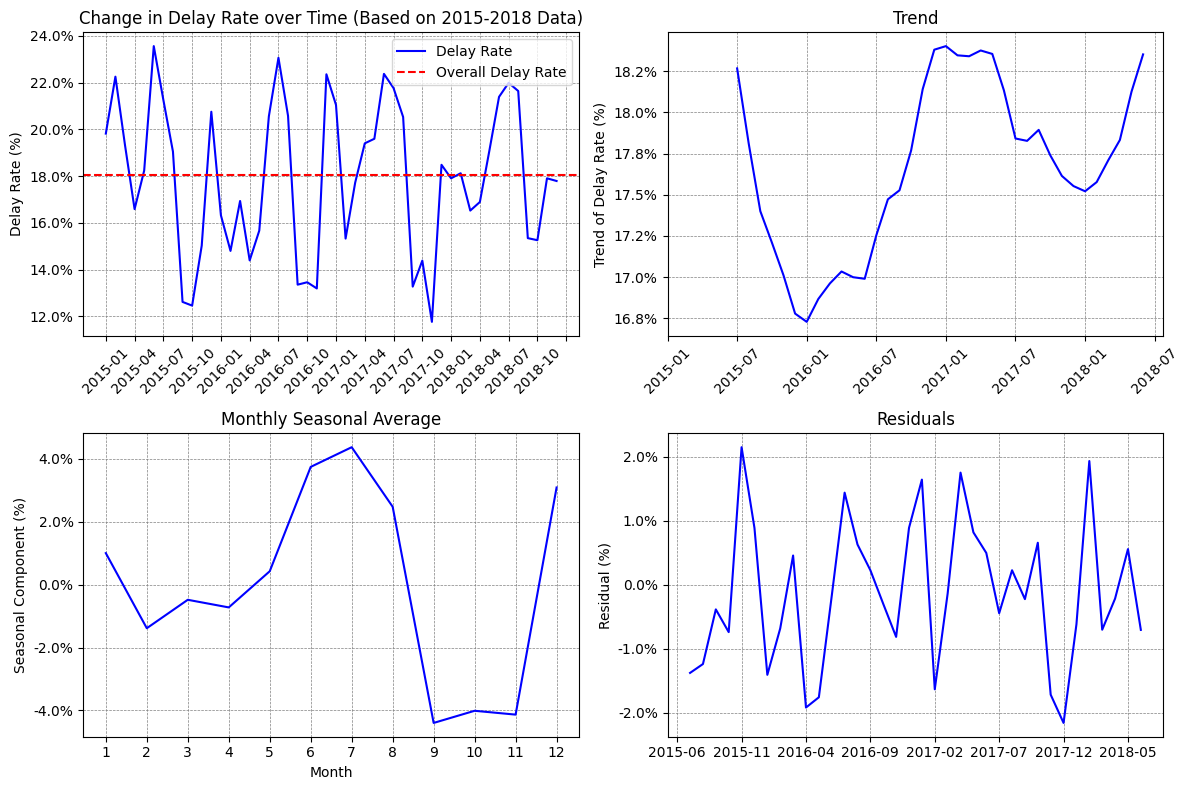

In [0]:
# Calculate average delay rate for each combination of year and month
avg_delay_pandas = df_otpw.groupBy("YEAR", "MONTH") \
    .agg(avg("DEP_DEL15").alias("avg_delay_rate")) \
    .toPandas()

# Calculate overall delay rate
overall_delay_rate = df_otpw.agg(avg("DEP_DEL15")).collect()[0][0]

# Create a combined Month-Year column for sorting
avg_delay_pandas["Month_Year"] = avg_delay_pandas["YEAR"].astype(str) + '-' + avg_delay_pandas["MONTH"].astype(str).str.zfill(2)
avg_delay_pandas = avg_delay_pandas.sort_values("Month_Year")

# Create the delay rate plot
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2, 2, 1)
plt.plot(avg_delay_pandas["Month_Year"], avg_delay_pandas["avg_delay_rate"], linestyle='-', color='blue', label='Delay Rate')
plt.axhline(y=overall_delay_rate, color='red', linestyle='--', label='Overall Delay Rate')
plt.xlabel("")
plt.ylabel("Delay Rate (%)")
plt.title("Change in Delay Rate over Time (Based on 2015-2018 Data)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Set gridlines for every 3 months
ax1.xaxis.set_major_locator(plt.MultipleLocator(base=3))
ax1.grid(which='both', axis='both', linestyle='--', color='grey', linewidth=0.5)

# Format Y-axis as percentages with one decimal point
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.1%}'))

# Time series decomposition
ts = avg_delay_pandas.set_index("Month_Year")["avg_delay_rate"]
decomposition = seasonal_decompose(ts, model='additive', period=12)

ax2 = plt.subplot(2, 2, 2)
decomposition.trend.plot(color='blue')
plt.title("Trend")
plt.xlabel("")
plt.ylabel("Trend of Delay Rate (%)")
plt.xticks(np.arange(0, len(avg_delay_pandas), step=6), avg_delay_pandas["Month_Year"][::6], rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.1%}'))
ax2.grid(which='both', axis='both', linestyle='--', color='grey', linewidth=0.5)
plt.tight_layout()

ax3 = plt.subplot(2, 2, 3)

# Show only the first 12 months starting from January
start_index = list(ts.index).index("2018-01")
decomposition.seasonal[start_index:start_index+12].plot(color='blue')
plt.title("Monthly Seasonal Average")
plt.xlabel("Month")
plt.ylabel("Seasonal Component (%)")
plt.xticks(np.arange(0, 12), np.arange(1, 13))  # Adjust x-axis ticks to start from 1
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.1%}'))
ax3.grid(which='both', axis='both', linestyle='--', color='grey', linewidth=0.5)
plt.tight_layout()

ax4 = plt.subplot(2, 2, 4)
decomposition.resid.plot(color='blue')
plt.title("Residuals")
plt.xlabel("")
plt.ylabel("Residual (%)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.1%}'))
ax4.grid(which='both', axis='both', linestyle='--', color='grey', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

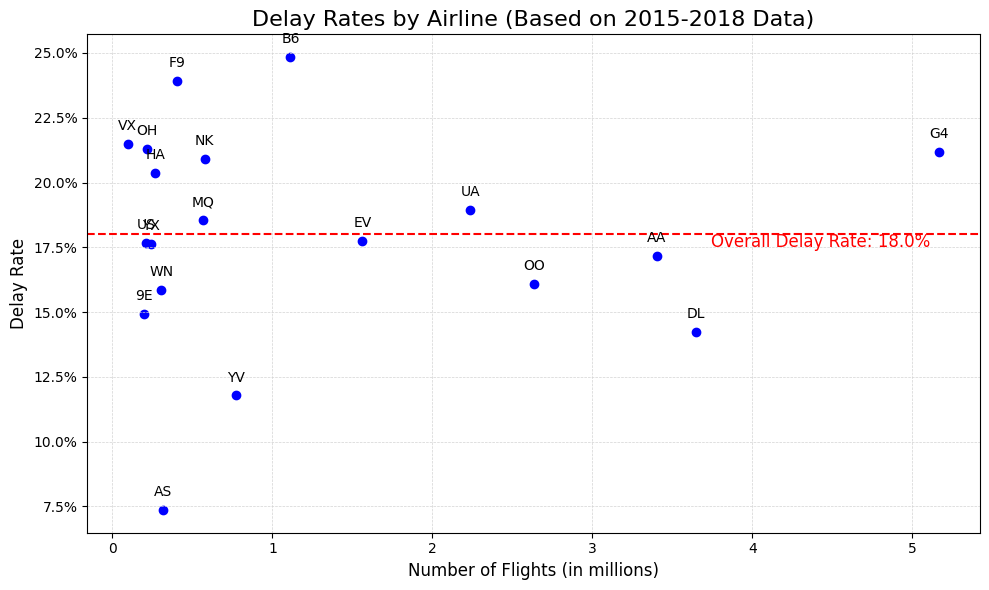

In [0]:
# Calculate precision and recall
df_otpw_by_airline = df_otpw.groupBy('OP_UNIQUE_CARRIER') \
    .agg(
        count('*').alias('flight_count'),
        avg('DEP_DEL15').alias('delay_rate'),
    )

# Extract relevant data from the DataFrame
airlines = df_otpw_by_airline.select('OP_UNIQUE_CARRIER').rdd.flatMap(lambda x: x).collect()
delay_rates = df_otpw_by_airline.select('delay_rate').rdd.flatMap(lambda x: x).collect()
flight_counts = df_otpw_by_airline.select('flight_count').rdd.flatMap(lambda x: x).collect()

# Calculate overall delay rate
overall_delay_rate = df_otpw.select(avg("DEP_DEL15")).collect()[0][0]

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(flight_counts, delay_rates, c='blue', marker='o')

# Add labels for each point (airline) with no overlap
label_offset = 0.05
label_positions = {}
for i, airline in enumerate(airlines):
    x = flight_counts[i]
    y = delay_rates[i]
    if y in label_positions:
        y += label_offset
    label_positions[y] = True
    plt.annotate(airline, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Add a line for the overall delay rate and label it
plt.axhline(y=overall_delay_rate, color='red', linestyle='--')

plt.annotate(
    f'Overall Delay Rate: {overall_delay_rate:.1%}', 
    xy=(4000000, overall_delay_rate * 1.06),
    xycoords='data',
    xytext=(-30, -30),
    textcoords='offset points', 
    color='red',
    fontsize=12
)

# Format the Y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# Set X-axis ticks to be in millions
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000000:.0f}'))

# Add light grey gridlines
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)

# Change title
plt.title('Delay Rates by Airline (Based on 2015-2018 Data)', fontsize=16)

# Labels and title
plt.xlabel('Number of Flights (in millions)', fontsize=12)
plt.ylabel('Delay Rate', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

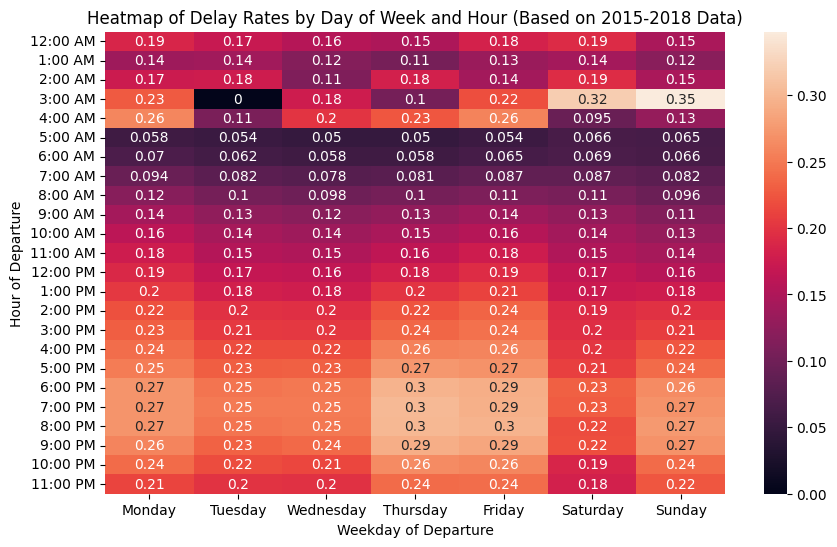

In [0]:
# Calculate precision and recall by hour of day and day of week
df_otpw_by_time = df_otpw.withColumn('hour_of_day', floor(col('CRS_DEP_TIME') / 100)) \
    .groupBy('hour_of_day', 'DAY_OF_WEEK') \
    .agg(
        count('*').alias('flight_count'),
        avg('DEP_DEL15').alias('delay_rate'),
    )

# For our labels
def convert_to_12_hour_format(hour):
    if hour == 0:
        return "12:00 AM"
    elif 1 <= hour <= 11:
        return f"{hour}:00 AM"
    elif hour == 12:
        return "12:00 PM"
    else:
        return f"{hour - 12}:00 PM"
    
ordered_hour_names = [convert_to_12_hour_format(hour) for hour in range(24)]

ordered_day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Pivot the DataFrame to create a heatmap matrix
heatmap_data = df_otpw_by_time.groupby("hour_of_day").pivot("DAY_OF_WEEK").agg(first("delay_rate")).orderBy('hour_of_day')

# Extract data for plotting
delay_rate_matrix = heatmap_data.drop('hour_of_day').toPandas().values

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(delay_rate_matrix, annot=True, xticklabels=ordered_day_names, yticklabels=ordered_hour_names)
plt.title("Heatmap of Delay Rates by Day of Week and Hour (Based on 2015-2018 Data)")
plt.xlabel("Weekday of Departure")
plt.ylabel("Hour of Departure")
plt.show()

We assessed the level of missingness on our features of interest. There is low missingness on our selected features (less than 5%), so we felt comfortable keeping all of them in our model. We decided to impute the mean to fill in missing values for numeric features. Otherwise, the machine learning algorithm would drop these rows wholesale from the analysis. We used mean rather than median, as median is less computationally burdensome for the big data world. For the same reason, we also created a missingness category to represent missing values for categorical features.

In [0]:
features_of_interest = [
    'AIR_TIME',
    'CRS_DEP_TIME',
    'DATE',
    'DAY_OF_WEEK',
    'DEP_TIME_BLK',
    'DEST',
    'DISTANCE',
    'ELEVATION',
    'FL_DATE',
    'MONTH',
    'OP_CARRIER_FL_NUM',
    'OP_UNIQUE_CARRIER',
    'ORIGIN',
    'TAIL_NUM',
    'YEAR',
    'dest_iata_code',
    'dest_type',
    'origin_iata_code',
    'origin_type',
    'sched_depart_date_time_UTC'
]

df_otpw_interest = df_otpw[features_of_interest]

num_rows = df_otpw_interest.count()

stacked_null_counts = df_otpw_interest.agg(*[F.sum(F.col(col).isNull().cast("int")).alias(col) for col in features_of_interest]) \
    .select(
        F.expr("stack({0}, {1})".format(len(features_of_interest), ", " \
                    .join(["'{}', {}, {}*100/{}".format(col, col, col, num_rows) for col in features_of_interest]))) \
        .alias("Column Name", "Missing Values", "Percent Null")) \
        .withColumn("Percent Null", F.col("Percent Null").cast(DoubleType())) \
        .orderBy('Percent Null', ascending=False) \
        .toPandas()

stacked_null_counts.display()

Column Name,Missing Values,Percent Null
AIR_TIME,59126,0.24712497679258813
CRS_DEP_TIME,0,0.0
DATE,0,0.0
DAY_OF_WEEK,0,0.0
DEP_TIME_BLK,0,0.0
DEST,0,0.0
DISTANCE,0,0.0
ELEVATION,0,0.0
FL_DATE,0,0.0
MONTH,0,0.0
